In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os

from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1
from AnalysisTables.place_fields import SortedDecodingGroup, OptoPlaceField, PlaceFieldCoverage
from Style.style_guide import animal_style

from Analysis.utils import filter_opto_data

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2025-02-19 09:03:55,739][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-02-19 09:03:55,770][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [17]:
coverage_thresh = 50
dlc = False
animal_list = ["transfected", "control"]
# animal_list =  ["control","transfected"]
# animal_list = animal_style.index
# animal_list = [a for a in animal_list if a not in ["Banner","Odins","control","transfected"]]
animal_list = ["transfected", "control"]
# wtrack settings
min_spikes = 10
max_spikes = 3000
interpolate = 200
coverage_thresh = 50
min_coverage = 5
track_type = "early_wtrack"

# #linear track settings
min_spikes = 100
max_spikes = 1000
interpolate = 100
coverage_thresh = 20
min_coverage = 5
track_type = "lineartrack"

animal_results = {}
for animal in animal_list:
    dataset_key = {
        "animal": animal,
        "track_type": track_type,
        # "period_ms": 100,
        # "track_type": "lineartrack",
        "targeted_phase": 90,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    all_results = {}
    dataset = filter_opto_data(dataset_key)
    for nwb_file_name, interval in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        key_list = []
        key_list.append(
            {
                "nwb_file_name": nwb_file_name,
                "decode_group_name": "DLC " + interval if dlc else interval,
            }
        )
        table = OptoPlaceField() & key_list
        if len(table) == 0:
            continue
        df = table.fetch_dataframe()
        table
        coverage_table = (
            PlaceFieldCoverage & key_list & {"unit_coverage_params_name": "50"}
        )
        coverage_df = coverage_table.fetch_dataframe()
        df = df.merge(coverage_df, on=["unit_id", "condition"])
        df = df[df.coverage < coverage_thresh]
        df = df[df.coverage > min_coverage]
        df = df[df.condition == "control"]

        k = (ClusterlessDecodingV1() & key_list).fetch("KEY", limit=1)[0]
        environment = (ClusterlessDecodingV1() & k).fetch_environments(k)[0]
        bin_loc = environment.place_bin_centers_
        pf_center_bins = np.array([np.argmax(x) for x in df.place_field.values])
        center_pos = bin_loc[pf_center_bins]

        df["center_pos"] = center_pos

        from ms_opto_stim_protocol import OptoStimProtocol

        opto_key = {"nwb_file_name": nwb_file_name, "interval_list_name": interval}
        stim, stim_time = (OptoStimProtocol() & opto_key).get_stimulus(opto_key)
        stim_time = stim_time[stim == 1]

        decode_key = (
            (SortedSpikesDecodingV1() & key_list & {"position_group_name": interval})
        ).fetch("KEY")[0]
        pos_df = SortedSpikesDecodingV1().fetch_linear_position_info(decode_key)
        stim_loc = pos_df.linear_position.values[np.digitize(stim_time, pos_df.index)]

        spike_times, spike_ids = (
            SortedSpikesDecodingV1() & decode_key
        ).fetch_spike_data(decode_key, return_unit_ids=True)

        window = 0.04
        for unit_id, spikes in zip(spike_ids, spike_times):
            unit_id = f"{str(unit_id['spikesorting_merge_id'])}_{unit_id['unit_id']}"
            if unit_id not in df.unit_id.values:
                continue
            place_center = df[df.unit_id == unit_id].center_pos.values[0]
            distances = []
            spike_counts = []
            for s, s_pos in zip(stim_time, stim_loc):
                distances.append(np.abs(s_pos - place_center))
                count = np.sum((spikes > s) & (spikes < s + window))
                spike_counts.append(count)
            all_results[unit_id] = {
                "distances": np.array(distances),
                "spike_counts": np.array(spike_counts),
            }
        # break
    animal_results[animal] = all_results
# df

datasets: 11


[09:16:53][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[2025-02-19 09:16:54,206][WARNING]: Skipped checksum for file with hash: 1f5c50a7-0065-fa56-18eb-45182d0fa2f5, and path: /stelmo/nwb/raw/Frodo20230810_.nwb
[09:16:54][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[09:16:55][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("

datasets: 7


[09:21:51][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[2025-02-19 09:21:52,259][WARNING]: Skipped checksum for file with hash: 7084610d-1911-ec9c-98b6-21f865ff9efd, and path: /stelmo/nwb/raw/Bilbo20230725_.nwb
[09:21:52][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[09:21:53][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("

In [3]:
from spyglass.decoding.v1.core import PositionGroup
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

# (SortedSpikesDecodingV1() & decode_key).fetch_linearized_position(decode_key)

In [ ]:
# spike_times, spike_ids = (SortedSpikesDecodingV1() & decode_key).fetch_spike_data(decode_key,return_unit_ids=True)

# window = .03
# all_results = {}
# for unit_id, spikes in zip(spike_ids,spike_times):
#     unit_id = f"{str(unit_id['spikesorting_merge_id'])}_{unit_id['unit_id']}"
#     if unit_id not in df.unit_id.values:
#         continue
#     place_center = df[df.unit_id==unit_id].center_pos.values[0]
#     distances =[]
#     spike_counts = []
#     for s, s_pos in zip(stim_time, stim_loc):
#         distances.append(np.abs(s_pos-place_center))
#         count = np.sum((spikes>s) & (spikes<s+window))
#         spike_counts.append(count)
#     all_results[unit_id] = {"distances":np.array(distances),"spike_counts":np.array(spike_counts)}

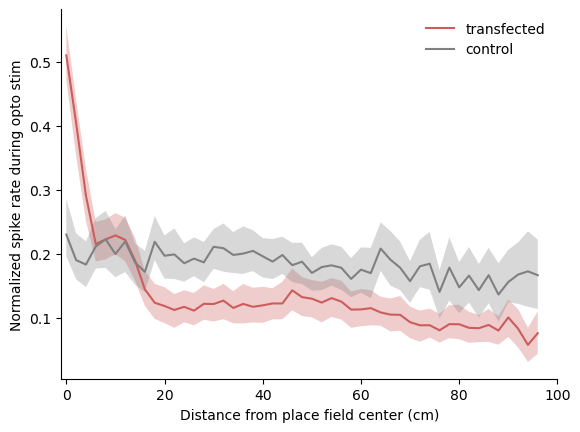

In [ ]:
from Analysis.utils import bootstrap_traces
from Style.style_guide import animal_style

distance_bins = np.arange(0, 100, 2)
fig = plt.figure()
ax = fig.add_subplot(111)
for animal, all_results in animal_results.items():
    curves = []
    for result in all_results.values():
        bin_avg = []
        for i, bin_start in enumerate(distance_bins[:-1]):
            bin_end = distance_bins[i + 1]
            ind = np.where(
                (bin_start <= result["distances"]) & (result["distances"] < bin_end)
            )[0]
            if len(ind) == 0:
                bin_avg.append(np.nan)
            else:
                bin_avg.append(np.mean(result["spike_counts"][ind]))
            # bin_avg.append(np.mean([x for x,d in zip(result["spike_counts"],result["distances"]) if bin_start<=d<bin_end]))
        # plt.plot(distance_bins, bin_avg / np.nanmax(bin_avg))
        curves.append(bin_avg / np.nanmax(bin_avg))
        # curves.append(bin_avg / np.mean(result["spike_counts"]))
    curves = np.array(curves)
    yy, rng = bootstrap_traces(curves, statistic=np.nanmean, n_boot=100)
    color = animal_style.loc[animal]["color"]
    plt.plot(distance_bins[:-1], yy, color=color, label=animal)
    plt.fill_between(
        distance_bins[:-1],
        *rng,
        facecolor=color,
        alpha=0.3,
    )
plt.xlabel("Distance from place field center (cm)")
plt.ylabel("Normalized spike rate during opto stim")
plt.legend(frameon=False)
ax.spines[["top", "right"]].set_visible(False)
plt.xlim([-1, 100])
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/stim_field_interact_linear_theta90.svg"
)

(array([ 22.,   0.,   0.,   0.,   0.,   3.,   6.,  70.,   9., 185.]),
 array([-6.90775528, -5.98672124, -5.0656872 , -4.14465317, -3.22361913,
        -2.30258509, -1.38155106, -0.46051702,  0.46051702,  1.38155106,
         2.30258509]),
 <BarContainer object of 10 artists>)

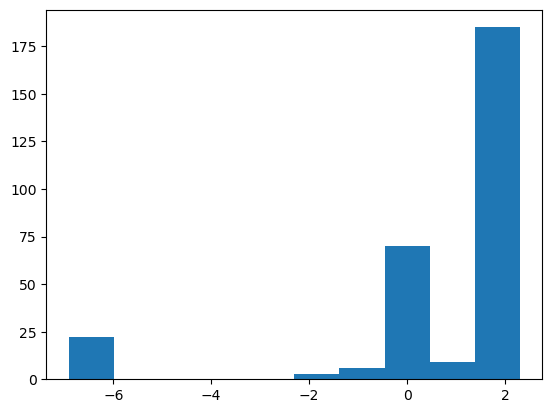

In [ ]:
all_results = animal_results["transfected"]
stats = []
for result in all_results.values():
    ind = np.where((result["distances"] < 20))[0]
    ind_far = np.where((result["distances"] > 20))[0]
    counts = result["spike_counts"]
    stats.append(np.nanmean(counts[ind]) / np.nanmean(counts[ind_far]))
stats = np.clip(stats, 0.001, 10)
stats = np.log(stats)
plt.hist(stats)

In [57]:
len(all_results)

307

In [78]:
bin_start, bin_end
result["distances"]

[15.06543855796653,
 14.391975147465203,
 14.069819084151163,
 13.911597740807721,
 13.63490347137693,
 12.842758010994842,
 11.528080370718925,
 9.169516912143834,
 6.528749774827361,
 5.032378507447746,
 3.957422049910164,
 3.3501128029534044,
 2.1278873594332737,
 1.5901510203385527,
 1.7351408434428492,
 1.3992410498309908,
 1.4124003793907605,
 1.4328206016496097,
 1.3585530078587595,
 1.337709381535845,
 1.4206748063109416,
 1.4309430710432025,
 1.42547663237508,
 1.4189800441706666,
 1.4189800441706666,
 1.4189800441706666,
 1.4879015170923395,
 1.4801181013805262,
 1.4147431388199863,
 1.4189800441706666,
 1.4189800441706666,
 1.403428109236387,
 1.6581557862201919,
 2.5722949006652556,
 3.189324679897851,
 3.5259990909585213,
 3.905948949611897,
 4.510761888710277,
 4.612320996966886,
 4.53451777871102,
 4.674614677989098,
 4.6625794604371436,
 4.6157300012720555,
 4.469025936002907,
 4.325360754571477,
 4.303575211764908,
 4.150778482330864,
 4.139774560198944,
 4.13977456019

In [8]:
# center_pos = bin_loc[np.clip(pf_center_bins,0,len(bin_loc)-1)]

[13:10:57][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already 

In [27]:
df.place_field.values[10].shape, bin_loc.shape, pf_center_bins.max()

((67,), (67, 1), 68)

In [12]:
environment.place_bin_centers_

array([[  0.99480719],
       [  2.98442157],
       [  4.97403595],
       [  6.96365033],
       [  8.95326471],
       [ 10.94287909],
       [ 12.93249347],
       [ 14.92210785],
       [ 16.91172223],
       [ 18.90133661],
       [ 20.89095099],
       [ 22.88056537],
       [ 24.87017975],
       [ 26.85979413],
       [ 28.84940851],
       [ 30.83902289],
       [ 32.82863727],
       [ 34.81825165],
       [ 36.80786603],
       [ 38.79748041],
       [ 40.78709479],
       [ 42.77670918],
       [ 44.76632356],
       [ 46.75593794],
       [ 48.74555232],
       [ 50.7351667 ],
       [ 52.72478108],
       [ 54.71439546],
       [ 56.70400984],
       [ 58.69362422],
       [ 60.6832386 ],
       [ 62.67285298],
       [ 64.66246736],
       [ 66.65208174],
       [ 68.64169612],
       [ 70.6313105 ],
       [ 72.62092488],
       [ 74.61053926],
       [ 76.60015364],
       [ 78.58976802],
       [ 80.5793824 ],
       [ 82.56899678],
       [ 84.55861116],
       [ 86